In this notebook we will look portfolios formed based on momentum, payout yield, and volatility.  We also look at a variation on the strategy of van Vliet and Blitz (VVB).

We start, as usual, by importing libraries:

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

The strategies will be analyzed using monthly data.  This is the same data I have used previously, but it has one new variable added, DIVAMT, which is the dividend amount.

In [2]:
msf = pd.read_feather('crsp_monthly.feather')

I will look at a more recent subsample:

In [3]:
msf = msf.loc[msf['DATE']>'1993-01-27']
#msf = msf.loc[msf['DATE']>'2015-01-27']

Now I'll clean up the data a bit.  Here are the steps taken in the following cell:
1. Keep common stocks (SHRCD=10 or 11) and drop the SHRCD collumn.
2. Get rid of negative prices, which are CRSP's way of indicating a stock that did not trade.
3. Define the market value of the firm as the product of shares outstanding and share price.
4. Set the index of the dataframe.
5. Sort by that index.
6. Drop rows that have missing values of some key variables.
7. Eliminate duplicate PERMNO/DATE observations.
8. Look at the dataframe.

In [4]:
# only keeping common stocks (excluding funds, ADRs, and other weird stuff):
msf = msf.loc[(msf['SHRCD']==10) | (msf['SHRCD']==11)]
msf.drop('SHRCD', axis=1, inplace=True)
msf['PRC'] = np.abs(msf['PRC'])
msf['MV']  = msf['SHROUT']*msf['PRC']
msf.set_index(['PERMNO','DATE'], inplace=True)
msf.sort_index(inplace=True)
msf.dropna(subset=['EXCHCD','PRC','VOL','SHROUT'], inplace=True)
msf = msf.groupby(['PERMNO','DATE']).head(1)
msf.head()

EXCHCD   SICCD     PRC    VOL       RET  SHROUT  DIVAMT  \
PERMNO  DATE                                                                  
10001.0 1993-01-29     3.0  4920.0  14.000   44.0  0.000000  1080.0     NaN   
        1993-02-26     3.0  4920.0  14.250   23.0  0.017857  1080.0     NaN   
        1993-03-31     3.0  4920.0  14.250  137.0  0.011053  1075.0  0.1575   
        1993-04-30     3.0  4920.0  15.250  473.0  0.070175  1075.0     NaN   
        1993-05-28     3.0  4920.0  15.125  126.0 -0.008197  1075.0     NaN   

                           MV  
PERMNO  DATE                   
10001.0 1993-01-29  15120.000  
        1993-02-26  15390.000  
        1993-03-31  15318.750  
        1993-04-30  16393.750  
        1993-05-28  16259.375

Next I will define lags of share price, market capitalization, and shares outstanding.

In [5]:
msf['lag_PRC']    = msf['PRC'].groupby('PERMNO').shift(1)
msf['lag_MV']     = msf['MV'].groupby('PERMNO').shift(1)
msf['lag_SHROUT'] = msf['SHROUT'].groupby('PERMNO').shift(1)

Here I define the lagged 6-month return.  I use a simple 6-month moving average with a one-month gap.  This is a little different from van Vliet and Blitz, who use the compounded 6-month return over the same period.

In [6]:
msf['lag RET'] = msf['RET'].groupby('PERMNO').shift(2)
msf['lag_RET_6m'] = msf['lag RET'].groupby('PERMNO').rolling(6).mean().droplevel(0)

Now computing the lagged payout yield.  To do so we replace missing dividends with zeros and then compute the total amount paid out by the firm.  This is the total amount of dividends paid (shares outstanding times dividends per share) plus the total value of any shares repuchased (a decline in the number of shares outstanding times the price per share).  Differently from van Vliet and Blitz, I am ignoring SEOs.  

In [7]:
msf['DIVAMT']          = msf['DIVAMT'].fillna(0)
msf['PAYOUT']          = msf['SHROUT']*msf['DIVAMT'] + np.maximum(msf['lag_SHROUT']-msf['SHROUT'], 0)*msf['PRC']
msf['lag_PAYOUT_1Y']   = msf['PAYOUT'].groupby('PERMNO').rolling(12).sum().shift(1).reset_index(level=0, drop=True)
msf['lag_PAYOUTYIELD'] = msf['lag_PAYOUT_1Y'] / msf['lag_MV']

Now we compute the lagged rolling standard deviation over the previous three years.

In [8]:
msf['lag_SD'] = msf['RET'].groupby('PERMNO').rolling(36).std().shift(1).reset_index(level=0, drop=True)

Once we have all our firm level variables defined, we swich the order of the index.  This will facilitate portfolio formation, which happens independently for each date.

In [9]:
msf = msf.reorder_levels(['DATE','PERMNO'])
msf.sort_index(inplace=True)
msf.tail()

EXCHCD   SICCD         PRC        VOL       RET  \
DATE       PERMNO                                                     
2022-06-30 93423.0     1.0  7389.0   21.700001   622028.0 -0.260647   
           93426.0     1.0  3676.0   29.129999     8297.0 -0.041776   
           93429.0     5.0  6211.0  113.190002   117240.0  0.007835   
           93434.0     3.0  9999.0    1.000000    39893.0 -0.212598   
           93436.0     3.0  9999.0  673.419983  6684634.0 -0.111888   

                       SHROUT  DIVAMT            MV     lag_PRC        lag_MV  \
DATE       PERMNO                                                               
2022-06-30 93423.0    86443.0     0.0  1.875813e+06   29.350000  2.537102e+06   
           93426.0    12621.0     0.0  3.676497e+05   30.400000  3.836784e+05   
           93429.0   106189.0     0.0  1.201953e+07  112.309998  1.192609e+07   
           93434.0    41560.0     0.0  4.156000e+04    1.270000  5.278120e+04   
           93436.0  1036010.0     0.0  6.976698e+08  758.260010  7.855650e+08   

                    lag_SHROUT   lag RET  lag_RET_6m  PAYOUT  lag_PAYOUT_1Y  \
DATE       PERMNO                                                             
2022-06-30 93423.0     86443.0 -0.120230   -0.006232     0.0       0.000000   
           93426.0     12621.0 -0.029238   -0.012308     0.0       0.000000   
           93429.0    106189.0 -0.012585   -0.023712     0.0  265845.097006   
           93434.0     41560.0 -0.352113   -0.161541     0.0       0.000000   
           93436.0   1036010.0 -0.191945   -0.031259     0.0       0.000000   

                    lag_PAYOUTYIELD    lag_SD  
DATE       PERMNO                              
2022-06-30 93423.0         0.000000  0.196106  
           93426.0         0.000000  0.095917  
           93429.0         0.022291  0.070138  
           93434.0         0.000000  0.180769  
           93436.0         0.000000  0.229402

Like VVB, I do not want to include very small firms.  Here's the approach I will take.  First, I will look at the subsample of firms that are listed on the NYSE.  The NYSE tends to have large firms (unlike NASDAQ), so the 30th percentile should not be too small.  I find what the 30th percentile of market capitalization is for each month of the sample, and I only keep firms that are above that value.

In [10]:
nyse                 = msf.loc[msf['EXCHCD']==1]
sizecut              = nyse['lag_MV'].groupby('DATE').quantile(q=.3)
msf['zero']          = 0
msf['NYSE30']        = msf['zero'] + sizecut 
msf['ABOVE_SIZECUT'] = msf['lag_MV'] >= msf['NYSE30']

In [11]:
msfsub = msf.loc[msf['ABOVE_SIZECUT']==True].copy()
msfsub.tail()

EXCHCD   SICCD         PRC        VOL       RET  \
DATE       PERMNO                                                     
2022-06-30 93369.0     3.0  8741.0   20.959999   246442.0 -0.023754   
           93374.0     1.0  6361.0   52.919998   176367.0 -0.118171   
           93423.0     1.0  7389.0   21.700001   622028.0 -0.260647   
           93429.0     5.0  6211.0  113.190002   117240.0  0.007835   
           93436.0     3.0  9999.0  673.419983  6684634.0 -0.111888   

                       SHROUT  DIVAMT            MV     lag_PRC        lag_MV  \
DATE       PERMNO                                                               
2022-06-30 93369.0   279705.0    0.00  5.862617e+06   21.469999  6.005266e+06   
           93374.0   107405.0    0.51  5.683872e+06   60.590000  6.507669e+06   
           93423.0    86443.0    0.00  1.875813e+06   29.350000  2.537102e+06   
           93429.0   106189.0    0.00  1.201953e+07  112.309998  1.192609e+07   
           93436.0  1036010.0    0.00  6.976698e+08  758.260010  7.855650e+08   

                    lag_SHROUT   lag RET  lag_RET_6m        PAYOUT  \
DATE       PERMNO                                                    
2022-06-30 93369.0    279705.0 -0.158445    0.011643      0.000000   
           93374.0    107405.0 -0.100432   -0.033009  54776.548976   
           93423.0     86443.0 -0.120230   -0.006232      0.000000   
           93429.0    106189.0 -0.012585   -0.023712      0.000000   
           93436.0   1036010.0 -0.191945   -0.031259      0.000000   

                    lag_PAYOUT_1Y  lag_PAYOUTYIELD    lag_SD  zero  \
DATE       PERMNO                                                    
2022-06-30 93369.0   30329.780315         0.005051  0.120158     0   
           93374.0  374341.438919         0.057523  0.078013     0   
           93423.0       0.000000         0.000000  0.196106     0   
           93429.0  265845.097006         0.022291  0.070138     0   
           93436.0       0.000000         0.000000  0.229402     0   

                          NYSE30  ABOVE_SIZECUT  
DATE       PERMNO                                
2022-06-30 93369.0  1.004611e+06           True  
           93374.0  1.004611e+06           True  
           93423.0  1.004611e+06           True  
           93429.0  1.004611e+06           True  
           93436.0  1.004611e+06           True

Before implementing the VVB strategy, I first want to construct a benchmark.  The VVB strategy is equally weighted, so my benchmark will be equally weighted as well.  I will also only use the stocks that exceed the minimum market cap.  This gets me the following:

In [12]:
benchret = msfsub[['RET']].groupby('DATE').mean()
benchret.head()

,RET
DATE,
1993-02-26,-0.010810
1993-03-31,0.033772
1993-04-30,-0.030269
1993-05-28,0.039880
1993-06-30,0.007423


I would also like to look at the performance relative to SPY.  I download SPY data using the YFinance library.  I then compute daily returns.  (The calculation is valid because SPY has bever had a split.)  I then convert returns to cumulative portfolio values, keep end of month values only, and compute monthly returns.

In [13]:
spydata              = yf.Ticker('SPY').history(period="max")
spydata.index.names  = ['DATE']
spydata['DAYRET']    = (spydata['Close']+spydata['Dividends']) / spydata['Close'].shift() - 1
spydata['PORTVAL']   = (1 + spydata['DAYRET']).cumprod()
spydata['DATE']      = pd.to_datetime(spydata.index.date)
spydata['yearmonth'] = spydata.index.year*100 + spydata.index.month
spydata              = spydata.loc[spydata['yearmonth'] < spydata['yearmonth'].shift(-1)]
spydata['RET']       = spydata['PORTVAL'].pct_change()
spydata              = spydata.reset_index(drop=True).set_index('DATE')
spydata.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,DAYRET,PORTVAL,yearmonth,RET
DATE,,,,,,,,,,,
1993-01-29,25.352047,25.352047,25.225917,25.334028,1003200,0.0,0,NaN,NaN,199301,NaN
1993-02-26,25.622314,25.622314,25.478166,25.604296,66200,0.0,0,0.001409,1.010668,199302,NaN
1993-03-31,26.268354,26.340768,26.177835,26.177835,111600,0.0,0,-0.000691,1.041744,199303,0.030748
1993-04-30,25.562299,25.652817,25.507988,25.507988,88500,0.0,0,0.001422,1.015088,199304,-0.025588
1993-05-28,26.304550,26.304550,26.069203,26.195929,79100,0.0,0,-0.004814,1.042464,199305,0.026970


In [14]:
benchret['SPYRET'] = spydata['RET']
benchret.head()

,RET,SPYRET
DATE,,
1993-02-26,-0.010810,NaN
1993-03-31,0.033772,0.030748
1993-04-30,-0.030269,-0.025588
1993-05-28,0.039880,0.026970
1993-06-30,0.007423,0.015900


I'm going to convert all returns to excess returns.  (And I won't change the names, which is a little sloppy.)  I'll start by downloading T-bill yields and computing monthly risk-free returns.

In [15]:
irxdata              = yf.Ticker('^IRX').history(period="max")
irxdata.index.names  = ['DATE']
irxdata['yearmonth'] = irxdata.index.year*100 + irxdata.index.month
irxdata              = irxdata.loc[irxdata['yearmonth'] < irxdata['yearmonth'].shift(-1)]
irxdata['rfret']     = irxdata['Close'].shift() / 100 / 12
irxdata              = irxdata[['rfret']].dropna()
irxdata.head()

,rfret
DATE,
1960-02-29,0.003325
1960-03-31,0.003492
1960-04-29,0.002517
1960-05-31,0.002533
1960-06-30,0.002600


Now I will subtract the risk-free return from the returns in msfsub and the two benchmark returns.

In [16]:
msfsub        = msfsub.merge(irxdata, how='left', on='DATE')
msfsub['RET'] = msfsub['RET'] - msfsub['rfret']

benchret           = benchret.merge(irxdata, how='left', on='DATE')
benchret['RET']    = benchret['RET']    - benchret['rfret']
benchret['SPYRET'] = benchret['SPYRET'] - benchret['rfret']

Here I create functions for computing quintile and decile ranks.

In [17]:
def quintiles(inser):
    outser = pd.qcut(inser, q=5, labels=range(1,6))
    return outser

def deciles(inser):
    outser = pd.qcut(inser, q=10, labels=range(1,11))
    return outser

Now I make sure that all my key variables are observed:

In [18]:
msfsub.dropna(inplace=True, subset=['lag_RET_6m','lag_PAYOUTYIELD','lag_SD','RET'])
msfsub.tail()

,EXCHCD,SICCD,PRC,VOL,RET,SHROUT,DIVAMT,MV,lag_PRC,lag_MV,...,lag RET,lag_RET_6m,PAYOUT,lag_PAYOUT_1Y,lag_PAYOUTYIELD,lag_SD,zero,NYSE30,ABOVE_SIZECUT,rfret
DATE,,,,,,,,,,,,,,,,,,,,,
2022-06-30,3.0,8741.0,20.959999,246442.0,-0.024612,279705.0,0.00,5.862617e+06,21.469999,6.005266e+06,...,-0.158445,0.011643,0.000000,30329.780315,0.005051,0.120158,0,1.004611e+06,True,0.000858
2022-06-30,1.0,6361.0,52.919998,176367.0,-0.119030,107405.0,0.51,5.683872e+06,60.590000,6.507669e+06,...,-0.100432,-0.033009,54776.548976,374341.438919,0.057523,0.078013,0,1.004611e+06,True,0.000858
2022-06-30,1.0,7389.0,21.700001,622028.0,-0.261506,86443.0,0.00,1.875813e+06,29.350000,2.537102e+06,...,-0.120230,-0.006232,0.000000,0.000000,0.000000,0.196106,0,1.004611e+06,True,0.000858
2022-06-30,5.0,6211.0,113.190002,117240.0,0.006977,106189.0,0.00,1.201953e+07,112.309998,1.192609e+07,...,-0.012585,-0.023712,0.000000,265845.097006,0.022291,0.070138,0,1.004611e+06,True,0.000858
2022-06-30,3.0,9999.0,673.419983,6684634.0,-0.112746,1036010.0,0.00,6.976698e+08,758.260010,7.855650e+08,...,-0.191945,-0.031259,0.000000,0.000000,0.000000,0.229402,0,1.004611e+06,True,0.000858


In this cell, I am computing quintile ranks.

I am doing something a little unusual in the first line.  Because payout yield is zero for more than 20% of all stocks, there is no way to determine which stocks are in quintile 1 and which are in quintile 2.  I therefore "cheat" and add a very small and more or less random number to each firm's payout yield.  This allows me to sort, but it should be clear that the first two quintiles sorted on payout yield will me somewhat randomly chosen.

In [19]:
msfsub['lag_PAYOUTYIELD']   = msfsub['lag_PAYOUTYIELD'] + msfsub['lag_PRC']/10000000000

msfsub['MOMENTUM_QUINTILE'] = msfsub['lag_RET_6m'].groupby('DATE').apply(quintiles)
msfsub['PAYOUT_QUINTILE']   = msfsub['lag_PAYOUTYIELD'].groupby('DATE').apply(quintiles)
msfsub['RISK_QUINTILE']     = msfsub['lag_SD'].groupby('DATE').apply(quintiles)

Computing portfolio returns for the quintile sorts:

In [20]:
momentum_ports = msfsub.groupby(['MOMENTUM_QUINTILE','DATE'])['RET'].mean()
payout_ports   = msfsub.groupby(['PAYOUT_QUINTILE','DATE'])['RET'].mean()
risk_ports     = msfsub.groupby(['RISK_QUINTILE','DATE'])['RET'].mean()

The following three cells contain performance statistics for the three univariate sorts:

In [21]:
msfsub.head()

,EXCHCD,SICCD,PRC,VOL,RET,SHROUT,DIVAMT,MV,lag_PRC,lag_MV,...,lag_PAYOUT_1Y,lag_PAYOUTYIELD,lag_SD,zero,NYSE30,ABOVE_SIZECUT,rfret,MOMENTUM_QUINTILE,PAYOUT_QUINTILE,RISK_QUINTILE
DATE,,,,,,,,,,,,,,,,,,,,,
1996-01-31,1.0,6211.0,48.75,15559.0,0.149713,15517.0,0.0,756453.75,42.250,655593.25,...,38729.150004,5.907497e-02,0.093643,0,302447.55,True,0.004133,4,5,4
1996-01-31,3.0,3570.0,46.00,1715912.0,0.004086,183306.0,0.0,8432076.00,45.625,8363336.25,...,477414.000000,5.708416e-02,0.102972,0,302447.55,True,0.004133,5,5,4
1996-01-31,3.0,6320.0,23.00,8750.0,0.214410,38220.0,0.0,879060.00,18.875,721402.50,...,0.000000,1.887500e-09,0.080076,0,302447.55,True,0.004133,4,1,3
1996-01-31,3.0,7370.0,47.75,1068644.0,0.122710,435304.0,0.0,20785766.00,42.375,18446007.00,...,0.000000,4.237500e-09,0.082829,0,302447.55,True,0.004133,4,1,3
1996-01-31,3.0,7370.0,92.50,1294123.0,0.049998,590000.0,0.0,54575000.00,87.750,51772500.00,...,0.000000,8.775000e-09,0.075252,0,302447.55,True,0.004133,2,2,3


In [22]:
momentum_stats = momentum_ports.groupby(['MOMENTUM_QUINTILE']).describe()
momentum_stats['sharpe'] = momentum_stats['mean'] / momentum_stats['std'] * np.sqrt(12)
momentum_stats

,count,mean,std,min,25%,50%,75%,max,sharpe
MOMENTUM_QUINTILE,,,,,,,,,
1,318.0,0.006918,0.070892,-0.246549,-0.031912,0.012766,0.044629,0.362984,0.338046
2,318.0,0.008536,0.051956,-0.208964,-0.019777,0.011959,0.039046,0.235679,0.569140
3,318.0,0.008100,0.047151,-0.194006,-0.016906,0.012597,0.034365,0.169655,0.595117
4,318.0,0.007285,0.048042,-0.193421,-0.019084,0.013183,0.035885,0.149084,0.525266
5,318.0,0.010291,0.066462,-0.208347,-0.022264,0.012824,0.046069,0.380842,0.536403


In [23]:
payout_stats = payout_ports.groupby(['PAYOUT_QUINTILE']).describe()
payout_stats['sharpe'] = payout_stats['mean'] / payout_stats['std'] * np.sqrt(12)
payout_stats

,count,mean,std,min,25%,50%,75%,max,sharpe
PAYOUT_QUINTILE,,,,,,,,,
1,318.0,0.006702,0.070785,-0.250026,-0.032370,0.012927,0.049813,0.210230,0.327997
2,318.0,0.007461,0.059630,-0.219222,-0.023332,0.011888,0.042802,0.239689,0.433424
3,318.0,0.008140,0.047399,-0.177872,-0.014291,0.011002,0.035906,0.150112,0.594890
4,318.0,0.009027,0.046171,-0.201493,-0.014006,0.013907,0.036701,0.160695,0.677302
5,318.0,0.009797,0.053602,-0.275017,-0.015377,0.013325,0.037988,0.228320,0.633111


In [24]:
risk_stats = risk_ports.groupby(['RISK_QUINTILE']).describe()
risk_stats['sharpe'] = risk_stats['mean'] / risk_stats['std'] * np.sqrt(12)
risk_stats

,count,mean,std,min,25%,50%,75%,max,sharpe
RISK_QUINTILE,,,,,,,,,
1,318.0,0.007833,0.034231,-0.138418,-0.011489,0.014103,0.027031,0.095996,0.792664
2,318.0,0.008553,0.044891,-0.187868,-0.015141,0.013271,0.035189,0.139726,0.660026
3,318.0,0.008665,0.052913,-0.235107,-0.017841,0.012833,0.039660,0.187772,0.567271
4,318.0,0.008121,0.060892,-0.230251,-0.025056,0.011913,0.045765,0.211817,0.461977
5,318.0,0.007948,0.090337,-0.270974,-0.034259,0.010546,0.060053,0.383672,0.304769


Now we are ready to implement something along the lines of VVB's conservative formula.

VVB look at stocks with standard deviations in the bottom 50%.  Since I already have quintiles determined, I will instead look at stocks in the bottom 40% (or quintiles 1 and 2).

In [25]:
lowrisk = msfsub.loc[msfsub['RISK_QUINTILE']<=2].copy()

Among these low risk stocks, I rank by past returns (I use 6 months instead of 12) and payout yield.  I then average the two ranks.

In [26]:
lowrisk['MOMENTUM_RANK'] = lowrisk.groupby('DATE')['lag_RET_6m'].rank(ascending = False, method = 'first')
lowrisk['PAYOUT_RANK']   = lowrisk.groupby('DATE')['lag_PAYOUTYIELD'].rank(ascending = False, method = 'first')
lowrisk['AVG_RANK']      = (lowrisk['MOMENTUM_RANK'] + lowrisk['PAYOUT_RANK'])/2

Now I form quintiles based on the average rank and compute performance statistics:

In [27]:
lowrisk['AVG_RANK_QUINTILE'] = lowrisk['AVG_RANK'].groupby('DATE').apply(quintiles)
vvb_ports = lowrisk.groupby(['AVG_RANK_QUINTILE','DATE'])['RET'].mean()

In [28]:
vvb_stats = vvb_ports.groupby(['AVG_RANK_QUINTILE']).describe()
vvb_stats['sharpe'] = vvb_stats['mean'] / vvb_stats['std'] * np.sqrt(12)
vvb_stats

,count,mean,std,min,25%,50%,75%,max,sharpe
AVG_RANK_QUINTILE,,,,,,,,,
1,318.0,0.008083,0.038751,-0.174580,-0.012142,0.012517,0.031156,0.127802,0.722604
2,318.0,0.007612,0.038750,-0.162468,-0.014512,0.011903,0.030137,0.114620,0.680466
3,318.0,0.007980,0.038908,-0.157923,-0.011346,0.013197,0.030637,0.121732,0.710468
4,318.0,0.008569,0.039229,-0.158937,-0.012884,0.013471,0.032277,0.120113,0.756729
5,318.0,0.008724,0.043987,-0.191237,-0.012004,0.012836,0.033909,0.141250,0.687050


Doing the same thing again, only now with deciles:

In [29]:
lowrisk['AVG_RANK_DECILE'] = lowrisk['AVG_RANK'].groupby('DATE').apply(deciles)
vvb_ports = lowrisk.groupby(['AVG_RANK_DECILE','DATE'])['RET'].mean()

In [30]:
vvb_stats = vvb_ports.groupby(['AVG_RANK_DECILE']).describe()
vvb_stats['sharpe'] = vvb_stats['mean'] / vvb_stats['std'] * np.sqrt(12)
vvb_stats

,count,mean,std,min,25%,50%,75%,max,sharpe
AVG_RANK_DECILE,,,,,,,,,
1,318.0,0.008850,0.039676,-0.166478,-0.013497,0.015757,0.033063,0.140858,0.772723
2,318.0,0.007318,0.038826,-0.182683,-0.011654,0.010352,0.029791,0.114745,0.652935
3,318.0,0.007339,0.038791,-0.159552,-0.014080,0.012526,0.031023,0.112260,0.655413
4,318.0,0.007890,0.039585,-0.168944,-0.013939,0.012557,0.030842,0.117111,0.690456
5,318.0,0.008001,0.038539,-0.163323,-0.010938,0.012300,0.031318,0.122274,0.719165
6,318.0,0.007972,0.040401,-0.152116,-0.013085,0.012949,0.032391,0.121181,0.683511
7,318.0,0.009040,0.040015,-0.161129,-0.011143,0.014320,0.033431,0.115914,0.782592
8,318.0,0.008106,0.039483,-0.156703,-0.011846,0.011375,0.032112,0.139724,0.711205
9,318.0,0.008736,0.042818,-0.181876,-0.012745,0.013425,0.033817,0.150449,0.706765


What is interesting is that there is no clear pattern in terms of average return.  Lower ranks are slightly better because of their lower SDs.  This is odd given that the ranking ordered firms by payout yield and momentum, neither of which is directly related to risk.  This is also quite different from the results in VVB, which may be due to the different sample period.

We can also compare it with the benchmark strategy:

In [31]:
bench_stats = benchret.describe()
bench_stats.loc['sharpe'] = bench_stats.loc['mean'] / bench_stats.loc['std'] * np.sqrt(12)
bench_stats[['RET','SPYRET']]

,RET,SPYRET
count,353.000000,352.000000
mean,0.007516,0.008821
std,0.053258,0.042627
min,-0.209522,-0.165937
25%,-0.019787,-0.014539
50%,0.012975,0.013474
75%,0.040958,0.035016
max,0.171544,0.126958
sharpe,0.488848,0.716846


Incredibly, the equally weighted return is worse than all 10 deciles.  Because all 10 deciles were constructed based on low risk stocks only, this tells us how important the low risk anomaly really is.

SPY's Sharpe ratio is only slightly below that of the top decile.  It is far better than the equally weighted portfolio.

Finally, let's take a look at performance over time:

In [32]:
cumret_1  = (1 + vvb_ports.loc[1]).cumprod()
cumret_10 = (1 + vvb_ports.loc[10]).cumprod()
cumret_B1 = (1 + benchret['RET'].iloc[35:]).cumprod()
cumret_B2 = (1 + benchret['SPYRET'].iloc[35:]).cumprod()

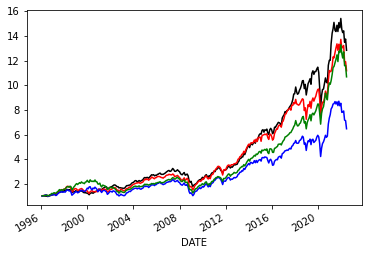

In [33]:
cumret_1.plot(color='black')
cumret_10.plot(color='red')
cumret_B1.plot(color='blue')
cumret_B2.plot(color='green')
plt.show()